In [123]:
# -----------------------------------
# 📦 1. IMPORT LIBRARIES
# -----------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Oversampling techniques
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, BorderlineSMOTE, SVMSMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

In [124]:
# -----------------------------------
# 📥 2. LOAD AND CLEAN DATA
# -----------------------------------
df = pd.read_csv("/kaggle/input/sleep-health-and-lifestyle-dataset/Sleep_health_and_lifestyle_dataset.csv")  # Replace with your dataset path

In [125]:
# Drop Person ID (not useful for prediction)
df.drop(columns=['Person ID'], inplace=True)

In [126]:
# Handle Missing Values
df.fillna(method='ffill', inplace=True)

In [127]:
# Blood Pressure split into Systolic and Diastolic
df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)
df.drop(columns=['Blood Pressure'], inplace=True)

In [128]:
# One-hot encode categorical columns
categorical_cols = ['Gender', 'Occupation', 'BMI Category']
df = pd.get_dummies(df, columns=categorical_cols)

In [129]:
# Encode target variable 'Sleep Disorder' (0: None, 1: Sleep Apnea, 2: Insomnia)
le = LabelEncoder()
df['Sleep Disorder'] = le.fit_transform(df['Sleep Disorder'])

In [130]:
# -----------------------------------
# ⚙️ 3. NORMALIZE NUMERICAL FEATURES
# -----------------------------------
scaler = StandardScaler()
num_cols = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
            'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [131]:
# -----------------------------------
# 🧪 4. FEATURE SELECTION
# -----------------------------------

# 1. Split X and y
X = df.drop('Sleep Disorder', axis=1)
y = df['Sleep Disorder']

# 2. Convert categorical features to numeric using Label Encoding or One-Hot Encoding
X_encoded = pd.get_dummies(X)

# 3. Scale features to [0,1] using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_encoded)

# 4. Apply Chi-squared test
selector = SelectKBest(score_func=chi2, k=10)
X_selected = selector.fit_transform(X_scaled, y)


In [132]:
# -----------------------------------
# 🔁 5. SPLIT DATA
# -----------------------------------
# Train-Test Split
# First split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_selected, y, test_size=0.3, random_state=42, stratify=y
)

# Second split (⚠️ without stratify to avoid error)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


In [133]:
# -----------------------------------
# 🔄 6. OVERSAMPLING TECHNIQUES
# -----------------------------------
# Define oversampling techniques with adjusted parameters for small classes
oversampling_techniques = {
    "SMOTE": SMOTE(random_state=42, k_neighbors=min(5, len(X_train)-1)),
    "ADASYN": ADASYN(random_state=42, n_neighbors=min(5, len(X_train)-1)),
    "RandomOverSampler": RandomOverSampler(random_state=42),
    "BorderlineSMOTE": BorderlineSMOTE(random_state=42, kind='borderline-1', k_neighbors=min(5, len(X_train)-1)),
    "SVMSMOTE": SVMSMOTE(random_state=42, k_neighbors=min(5, len(X_train)-1))
}

# Apply each oversampling technique and store results
oversampling_results = {}

for name, sampler in oversampling_techniques.items():
    try:
        print(f"\nApplying {name} oversampling...")
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        
        # Train a Random Forest classifier as an example
        model = RandomForestClassifier(random_state=42)
        model.fit(X_resampled, y_resampled)
        
        # Evaluate on validation set
        y_pred = model.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        oversampling_results[name] = acc
        print(f"{name} Accuracy: {acc:.4f}")
    except Exception as e:
        print(f"Error with {name}: {str(e)}")
        oversampling_results[name] = 0  # Assign 0 accuracy if oversampling fails

# Select the best oversampling technique
if oversampling_results:
    best_oversampler = max(oversampling_results, key=oversampling_results.get)
    print(f"\n✅ Best Oversampling Technique: {best_oversampler} with Accuracy: {oversampling_results[best_oversampler]:.4f}")

    # Apply the best oversampling technique to the training data
    best_sampler = oversampling_techniques[best_oversampler]
    X_train_os, y_train_os = best_sampler.fit_resample(X_train, y_train)
else:
    print("\n⚠️ No oversampling technique worked, using original data")
    X_train_os, y_train_os = X_train, y_train


Applying SMOTE oversampling...
Error with SMOTE: Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 6

Applying ADASYN oversampling...
Error with ADASYN: Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 6

Applying RandomOverSampler oversampling...
RandomOverSampler Accuracy: 0.7143

Applying BorderlineSMOTE oversampling...
Error with BorderlineSMOTE: Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 6

Applying SVMSMOTE oversampling...
Error with SVMSMOTE: Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 6

✅ Best Oversampling Technique: RandomOverSampler with Accuracy: 0.7143


In [134]:
# -----------------------------------
# 🧠 7. DEFINE CLASSIFICATION MODELS
# -----------------------------------
# Machine Learning Models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "MLP Classifier": MLPClassifier(random_state=42, max_iter=1000)
}

# Train models and evaluate them
results = {}
for name, model in models.items():
    try:
        print(f"\nTraining {name}...")
        model.fit(X_train_os, y_train_os)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[name] = acc
        print(f"{name} Accuracy: {acc:.4f}")
    except Exception as e:
        print(f"Error training {name}: {str(e)}")
        results[name] = 0  # Assign 0 accuracy if model fails


Training Logistic Regression...
Logistic Regression Accuracy: 0.6842

Training Naive Bayes...
Naive Bayes Accuracy: 0.5965

Training Decision Tree...
Decision Tree Accuracy: 0.7018

Training Random Forest...
Random Forest Accuracy: 0.7018

Training KNN...
KNN Accuracy: 0.8246

Training SVM...
SVM Accuracy: 0.6491

Training Gradient Boosting...
Gradient Boosting Accuracy: 0.7018

Training AdaBoost...
AdaBoost Accuracy: 0.3509

Training XGBoost...
XGBoost Accuracy: 0.6842

Training MLP Classifier...
MLP Classifier Accuracy: 0.6842


In [135]:
# -----------------------------------
# 🔀 8. DEFINE HYBRID MODELS
# -----------------------------------
if len(results) > 0:  # Only create hybrid models if we have successful base models
    hybrid_models = {
        "Voting (LR+RF+GB)": VotingClassifier(
            estimators=[
                ('lr', LogisticRegression(random_state=42, max_iter=1000)),
                ('rf', RandomForestClassifier(random_state=42)),
                ('gb', GradientBoostingClassifier(random_state=42))
            ], 
            voting='soft'
        ),
        "Voting (SVM+XGB+MLP)": VotingClassifier(
            estimators=[
                ('svm', SVC(probability=True, random_state=42)),
                ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
                ('mlp', MLPClassifier(random_state=42, max_iter=1000))
            ], 
            voting='soft'
        )
    }

    # Train hybrid models and evaluate them
    for name, model in hybrid_models.items():
        try:
            print(f"\nTraining {name}...")
            model.fit(X_train_os, y_train_os)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            results[name] = acc
            print(f"{name} Accuracy: {acc:.4f}")
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            results[name] = 0  # Assign 0 accuracy if model fails


Training Voting (LR+RF+GB)...
Voting (LR+RF+GB) Accuracy: 0.7018

Training Voting (SVM+XGB+MLP)...
Voting (SVM+XGB+MLP) Accuracy: 0.6842


In [136]:
# -----------------------------------
# 🏆 9. BEST MODEL SELECTION
# -----------------------------------
if results:
    best_model = max(results, key=results.get)
    print(f"\n✅ Best Model: {best_model} with Accuracy: {results[best_model]*100:.2f}%")


✅ Best Model: KNN with Accuracy: 82.46%


In [137]:
# -----------------------------------
# 🏆 9. BEST MODEL SELECTION AND EVALUATION
# -----------------------------------
if results:  # Check if we have any results
    best_model = max(results, key=results.get)
    print(f"\n✅ Best Model: {best_model} with Accuracy: {results[best_model]*100:.2f}%")
    
    # Get the best model instance
    if best_model in models:
        best_model_instance = models[best_model]
    else:
        best_model_instance = hybrid_models[best_model]
    
    # Generate predictions
    y_pred_best = best_model_instance.predict(X_test)
    
    # Print evaluation metrics
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_best))
    
    print("\nClassification Report:")
    # Convert class labels to strings if they're numeric
    target_names = [str(cls) for cls in le.classes_]
    print(classification_report(y_test, y_pred_best, target_names=target_names))

else:  # This else matches the if results:
    print("\n⚠️ No models were successfully trained")


✅ Best Model: KNN with Accuracy: 82.46%

Confusion Matrix:
[[37  2  0]
 [ 7 10  0]
 [ 1  0  0]]

Classification Report:
              precision    recall  f1-score   support

    Insomnia       0.82      0.95      0.88        39
 Sleep Apnea       0.83      0.59      0.69        17
         nan       0.00      0.00      0.00         1

    accuracy                           0.82        57
   macro avg       0.55      0.51      0.52        57
weighted avg       0.81      0.82      0.81        57




⚠️ Deep Learning models skipped due to error: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.


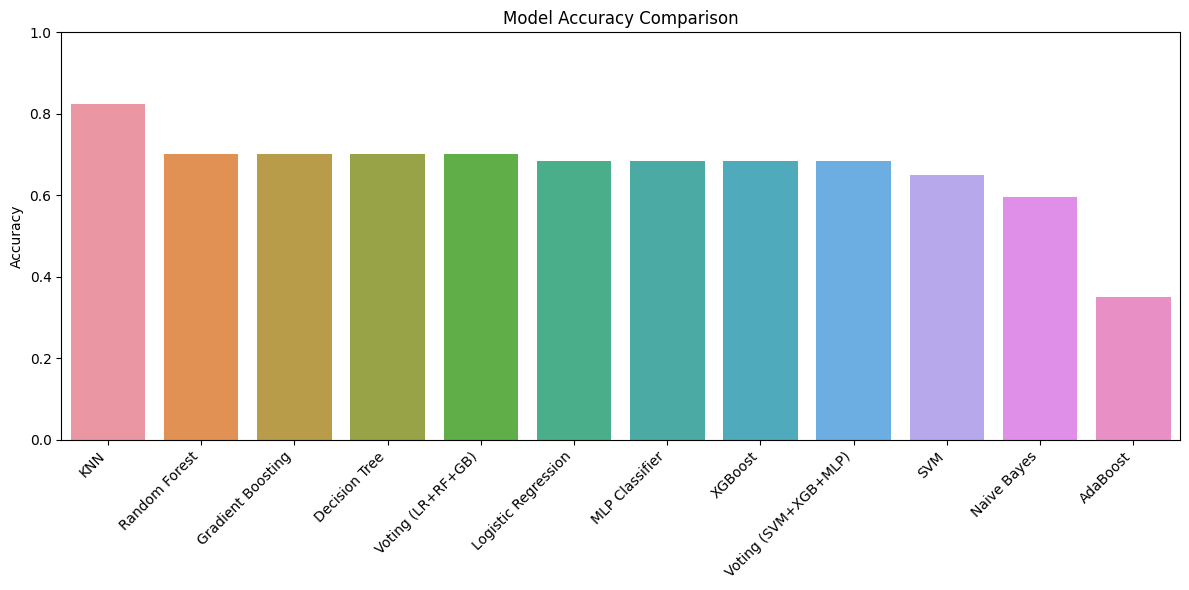

In [138]:
# -----------------------------------
# 📚 11. DEEP LEARNING MODELS (OPTIONAL)
# -----------------------------------
try:
    # One-hot encode target for deep learning
    y_dl = to_categorical(y)

    # Train-Test Split for Deep Learning
    X_train_dl, X_temp_dl, y_train_dl, y_temp_dl = train_test_split(X, y_dl, test_size=0.3, stratify=y, random_state=42)
    X_val_dl, X_test_dl, y_val_dl, y_test_dl = train_test_split(X_temp_dl, y_temp_dl, test_size=0.5, stratify=np.argmax(y_temp_dl, axis=1), random_state=42)

    # Define a function to build deep learning model
    def build_model(optimizer):
        model = Sequential()
        model.add(Dense(128, activation='relu', input_shape=(X.shape[1],)))
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(3, activation='softmax'))  # 3 classes: None, Sleep Apnea, Insomnia

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    # -----------------------------------
    # 🧪 MODEL 1 — Optimizer: Adam, Batch Size: 32, Epochs: 10
    # -----------------------------------
    print("\nTraining Deep Learning Model 1 (Adam)...")
    model1 = build_model('adam')
    history1 = model1.fit(X_train_dl, y_train_dl, 
                         validation_data=(X_val_dl, y_val_dl), 
                         epochs=10, batch_size=32, verbose=1)
    acc1 = model1.evaluate(X_test_dl, y_test_dl, verbose=0)[1]

    # -----------------------------------
    # 🧪 MODEL 2 — Optimizer: SGD, Batch Size: 64, Epochs: 20
    # -----------------------------------
    print("\nTraining Deep Learning Model 2 (SGD)...")
    model2 = build_model('sgd')
    history2 = model2.fit(X_train_dl, y_train_dl, 
                         validation_data=(X_val_dl, y_val_dl), 
                         epochs=20, batch_size=64, verbose=1)
    acc2 = model2.evaluate(X_test_dl, y_test_dl, verbose=0)[1]

    # -----------------------------------
    # 🏁 12. COMPARE DEEP LEARNING ACCURACIES
    # -----------------------------------
    print("\n✅ Deep Learning Optimizer Accuracy Comparison:")
    print(f"1. Adam     (batch=32, epoch=10)  -> Accuracy: {acc1:.4f}")
    print(f"2. SGD      (batch=64, epoch=20)  -> Accuracy: {acc2:.4f}")

except Exception as e:
    print(f"\n⚠️ Deep Learning models skipped due to error: {str(e)}")

# -----------------------------------
# 📈 13. VISUALIZATION
# -----------------------------------
if results:
    plt.figure(figsize=(12, 6))
    models_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
    models_df.sort_values(by='Accuracy', ascending=False, inplace=True)
    sns.barplot(x=models_df.index, y=models_df['Accuracy'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ No models to visualize")

In [140]:
from sklearn.metrics import roc_curve

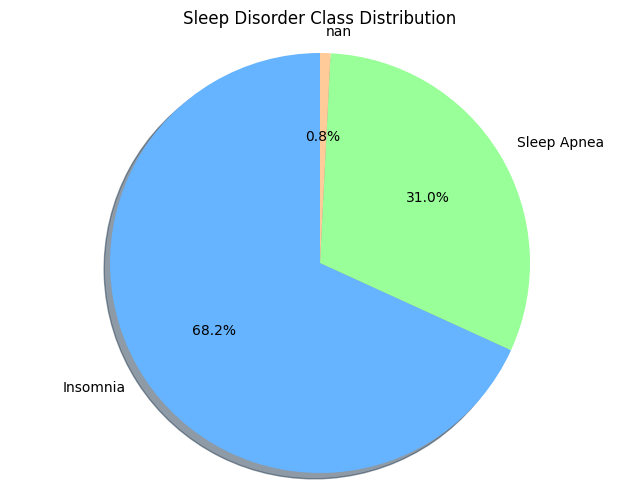

In [141]:
# -----------------------------------
# 📊 ENHANCED VISUALIZATIONS
# -----------------------------------

# 1. Target Class Distribution (Pie Chart)
plt.figure(figsize=(8, 6))
y_counts = df['Sleep Disorder'].value_counts()
plt.pie(y_counts, 
        labels=le.inverse_transform(y_counts.index), 
        autopct='%1.1f%%',
        colors=['#66b3ff','#99ff99','#ffcc99'],
        startangle=90,
        shadow=True)
plt.title('Sleep Disorder Class Distribution')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as circle
plt.show()

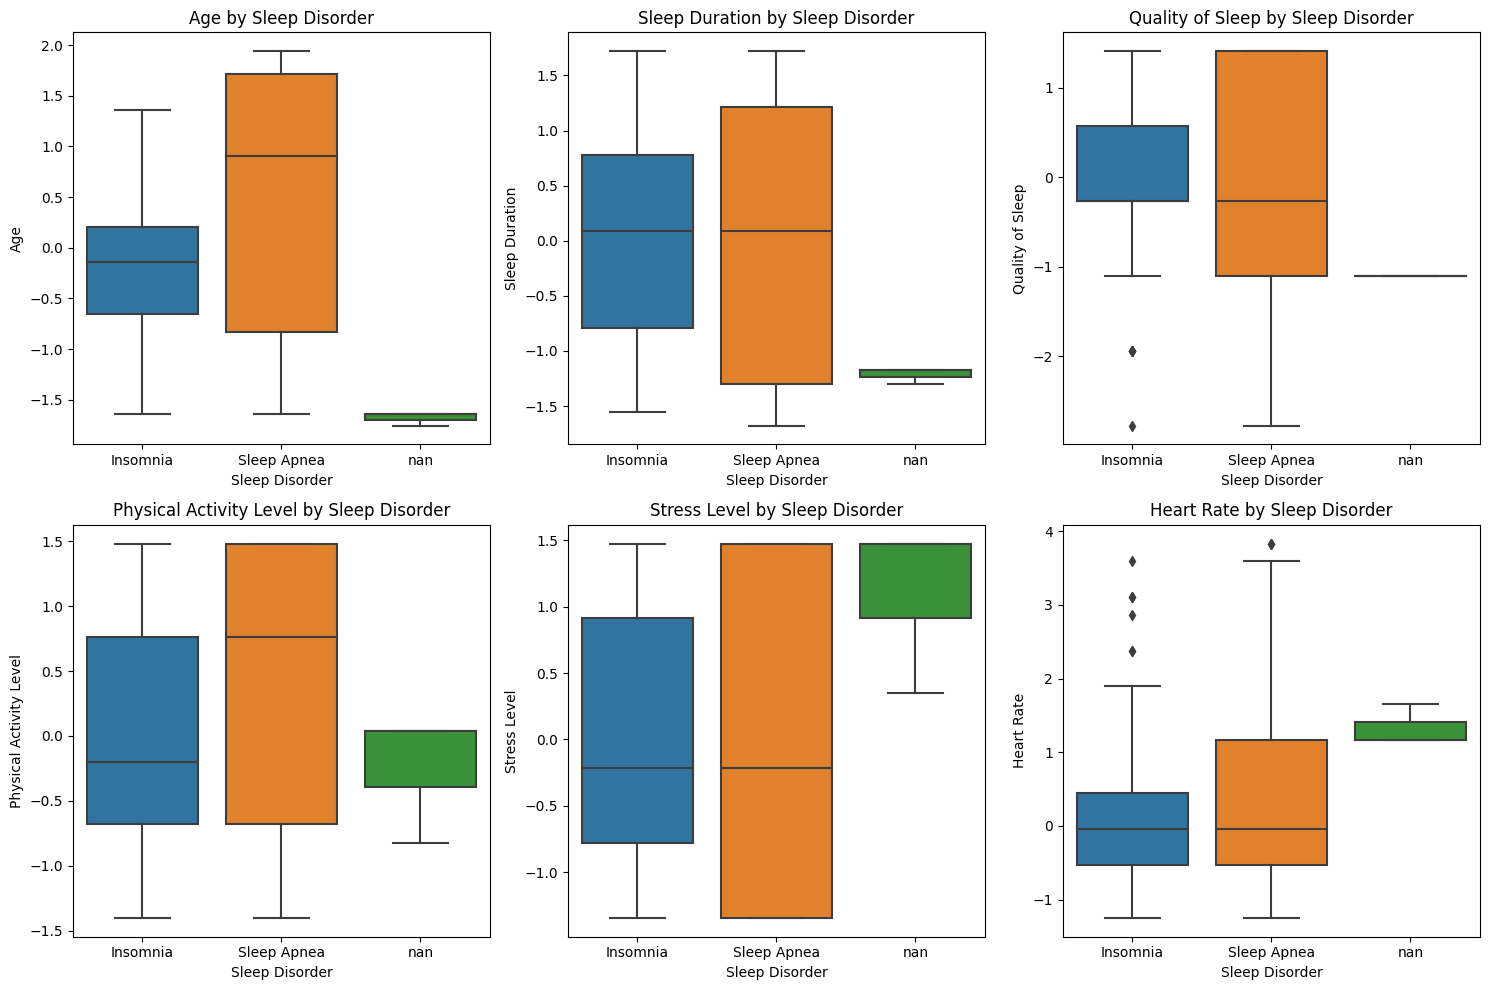

In [142]:
# 2. Feature Distributions by Class
plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_cols[:6]):  # Show first 6 numerical features
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Sleep Disorder', y=feature, data=df)
    plt.title(f'{feature} by Sleep Disorder')
    plt.xticks(ticks=[0,1,2], labels=le.classes_)
plt.tight_layout()
plt.show()

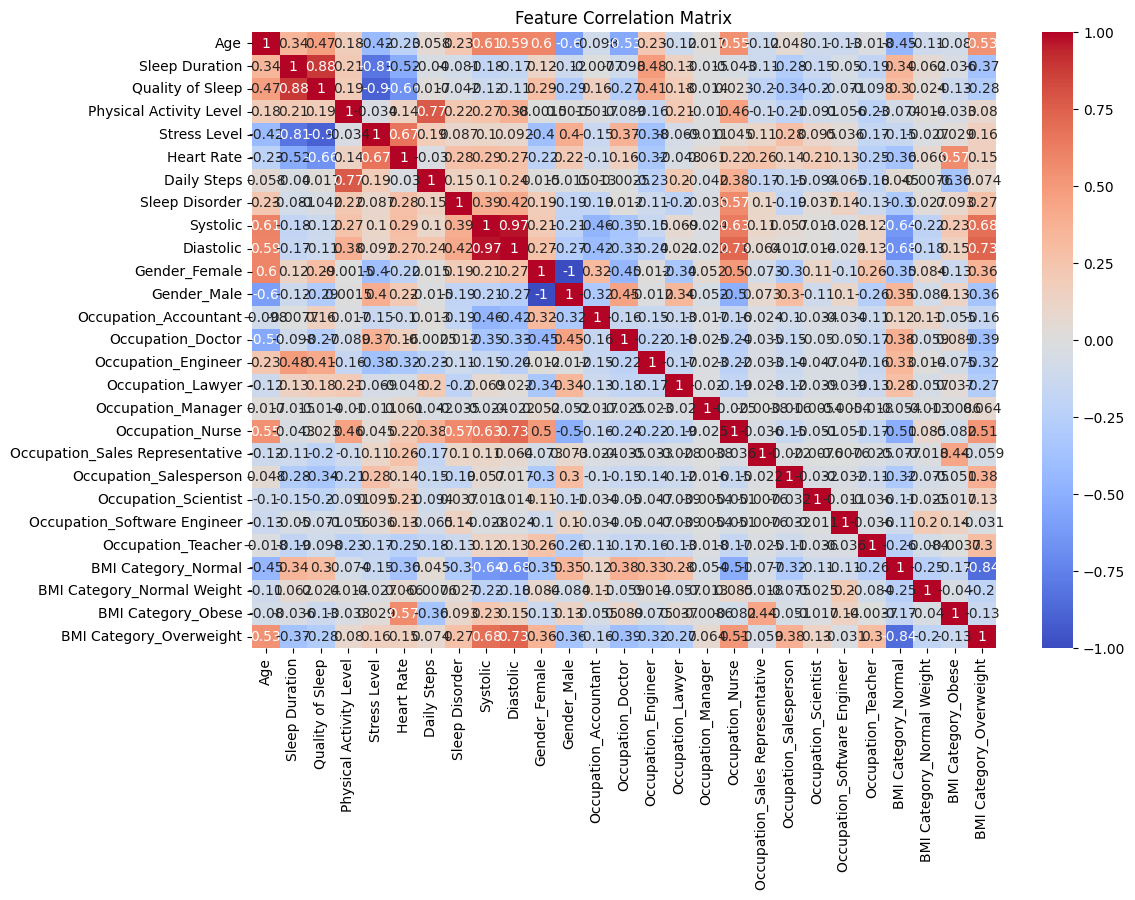

In [143]:

# 3. Correlation Heatmap
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()


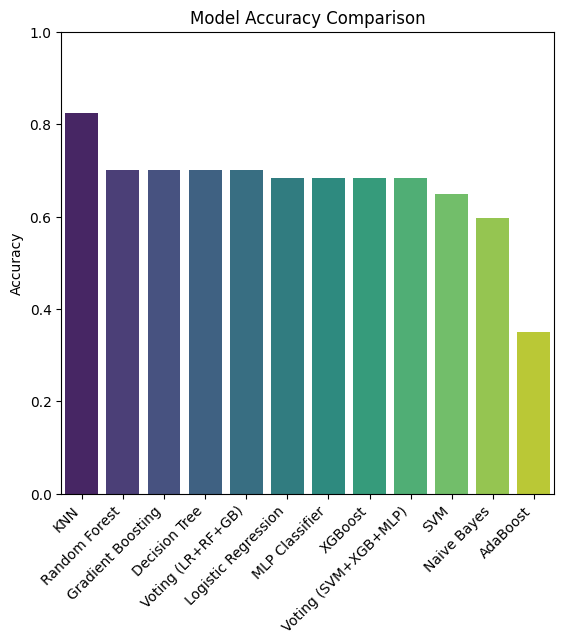

In [144]:
# 4. Model Performance Comparison (Enhanced)
if results:
    plt.figure(figsize=(14, 6))
    
    # Bar plot
    plt.subplot(1, 2, 1)
    models_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
    models_df = models_df.sort_values(by='Accuracy', ascending=False)
    sns.barplot(x=models_df.index, y=models_df['Accuracy'], palette='viridis')
    plt.xticks(rotation=45, ha='right')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 1)

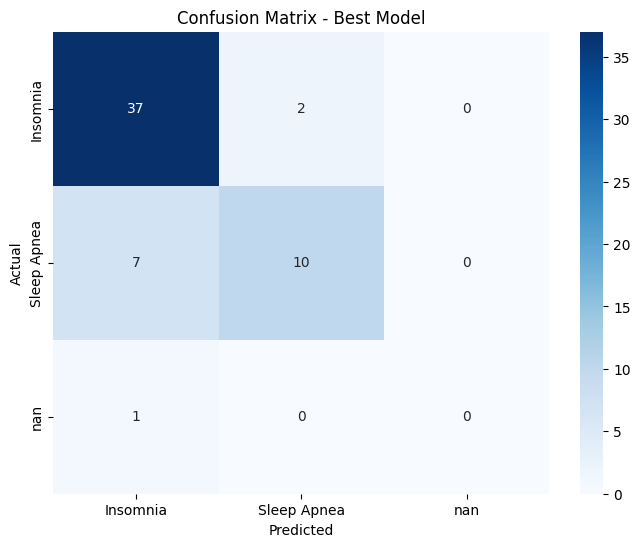

In [150]:
# 5. Confusion Matrix Visualization (if best model exists)
if results:
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred_best)
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=le.classes_, 
                yticklabels=le.classes_,
                cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Best Model')
    plt.show()